In [146]:
# Imports
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable

import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
import cvxpy as cp
import opinf


config = dotenv_values(".env")
from util import *

# Read in Data

In [147]:
# Setup filepaths for reading data
filepath = config["currentDirectory"] + "data/verificationData/controlTest12/"
# Read in system and gain matrices from .mat file
systemMats = scipy.io.loadmat(filepath + "romSystemMatricesAndGains_22dim_3train_2test.mat")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
L_era = systemMats["L_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
L_dmdc = systemMats["L_dmdc"]
# LOpInf Matrices
A_lopinf = systemMats["A_lopinf"]
B_lopinf = systemMats["B_lopinf"]
C_lopinf = systemMats["C_lopinf"]
D_lopinf = systemMats["D_lopinf"]
L_lopinf = systemMats["L_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

In [148]:
# Load in data from npy file
data = np.load(filepath + "processedData_policySeed_0.npz")

Y_fom = data["reducedCenterlineData"]
U_fom = data["inputData"].T
Y0_fom = data["reducedCenterlineData"][0,:]

timesteps = 1500# Y_fom.shape[0]

# RHC Analysis

In [149]:
# Read in data
# Initialize arrays to store data from online observer
y_groundTruth_online = np.zeros((C_era.shape[0], timesteps)) 
y_ref_online = np.zeros((C_era.shape[0], timesteps)) 
# Read in data from online observer
for i in range(timesteps):
    onlineObs_filename = filepath + "verification_step_" + str(i) + ".hdf5"
    with h5py.File(onlineObs_filename, 'r') as f:
        y_groundTruth_online[:,i] = f["y"][()].squeeze()
        y_ref_online[:,i] = f["y_ref"][()][:,0].squeeze()


## Control Inputs

The goal here is to analyze the control inputs a given trial

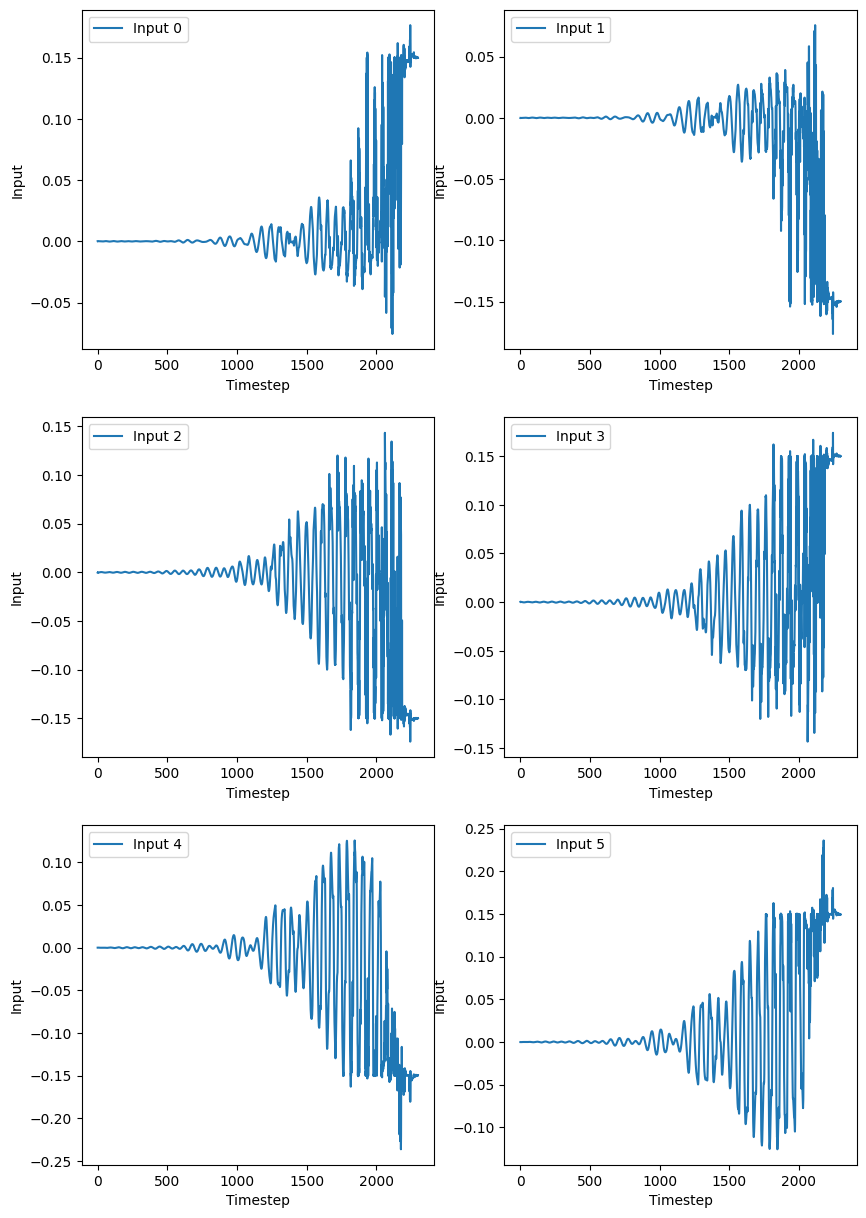

In [150]:
# Plot all 6 inputs separately on subplots
fig, axs = plt.subplots(3, 2, figsize=(10, 15))
for i in range(6):
    axs[i//2, i%2].plot(U_fom[i,:], label="Input " + str(i))
    axs[i//2, i%2].set_xlabel("Timestep")
    axs[i//2, i%2].set_ylabel("Input")
    axs[i//2, i%2].legend()

## Trajectory Tracking

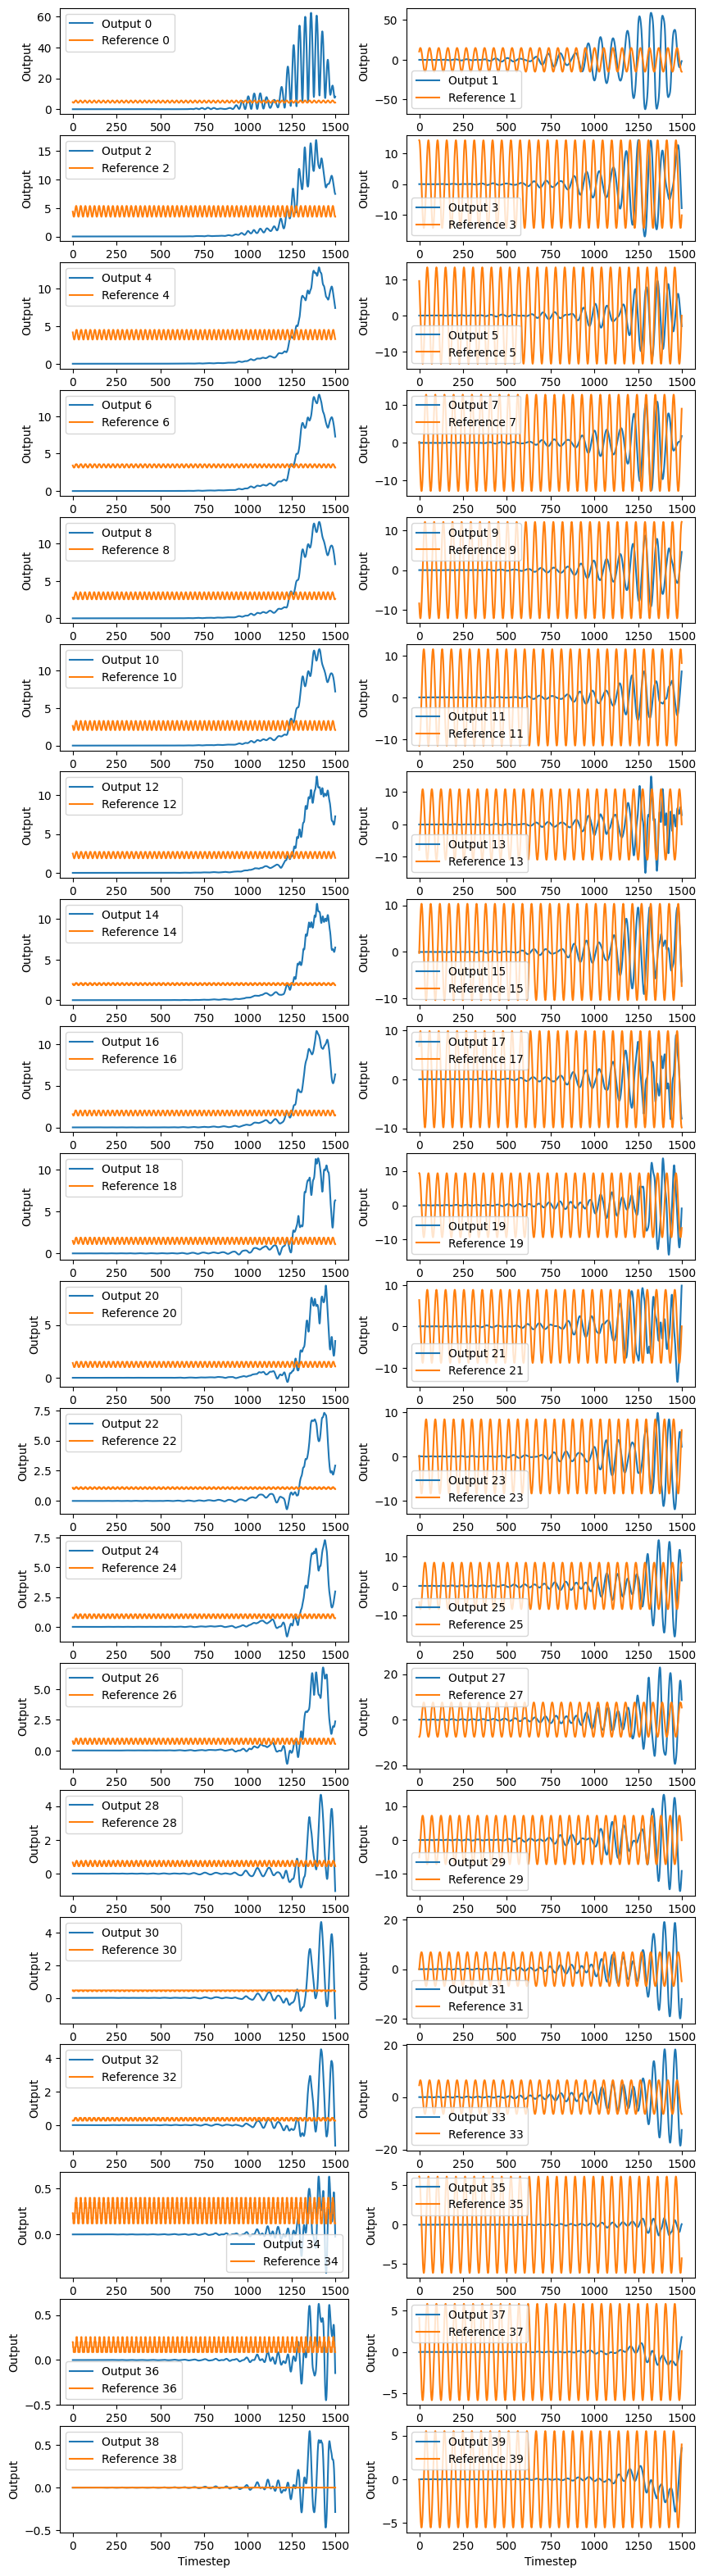

In [151]:
# Show output trajectories against reference trajectories for all 40 outputs
fig, axs = plt.subplots(20,2, figsize=(10, 40))
plotTimetsteps = timesteps
for i in range(40):
    axs[i//2, i%2].plot(y_groundTruth_online[i,:plotTimetsteps], label="Output " + str(i))
    axs[i//2, i%2].plot(y_ref_online[i,:plotTimetsteps], label="Reference " + str(i))
    axs[i//2, i%2].set_xlabel("Timestep")
    axs[i//2, i%2].set_ylabel("Output")
    axs[i//2, i%2].legend()

### Tracking video

Moviepy - Building video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/verificationData/controlTest12/outputCenterlineTrajectories.mp4.
Moviepy - Writing video /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/verificationData/controlTest12/outputCenterlineTrajectories.mp4



t:   0%|          | 0/1500 [00:00<?, ?it/s, now=None]

Moviepy - Done !
Moviepy - video ready /home/brdl/iman/dev/sofaProjects/anguilliformOptimalControl/data/verificationData/controlTest12/outputCenterlineTrajectories.mp4


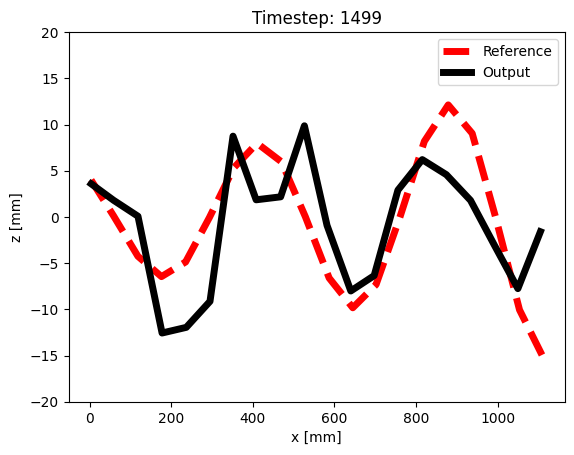

In [152]:
# Generate video of output centerline trajectories against reference centerline trajectories 
animationFilepath = filepath + "outputCenterlineTrajectories.mp4"
numFrames = timesteps
fps = 60
duration = numFrames/fps
# Set up figure for animation
fig, ax = plt.subplots()
# Animation callback
def animate(t):
    global y_groundTruth_online, y_ref_online, Y0_fom
    i = int(round(t*fps))
    ax.clear()
    # Reshape outputs
    output_i = y_groundTruth_online[:,i].reshape((20,2))
    output_i[:,0] = output_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate
    ref_i = y_ref_online[:,i].reshape((20,2))
    ref_i[:,0] = ref_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate
    ax.plot(-ref_i[:,0], ref_i[:,1], label="Reference", linewidth = 5, color = 'red', linestyle='dashed', ) # flip x sign to make things look nicer
    ax.plot(-output_i[:,0], output_i[:,1], label="Output", linewidth = 5, color = 'k') # flip x sign to make things look nicer
    ax.set_xlabel("x [mm]")
    ax.set_ylabel("z [mm]")
    # Set axis limits
    ax.set_ylim([-20, 20])
    # ax.set_xlim([-5, 2000])
    ax.set_title("Timestep: " + str(i))
    ax.legend()
    return mplfig_to_npimage(fig)

animation = VideoClip(animate, duration=duration)
animation.write_videofile(animationFilepath, fps=fps)

In [153]:
i = 10
output_i = y_groundTruth_online[:,i].reshape((20,2))
# output_i[:,0] = output_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate
ref_i = y_ref_online[:,i].reshape((20,2))
# ref_i[:,0] = ref_i[:,0] +  Y0_fom.reshape((20,2))[:,0] # Only offset the x coordinate


In [154]:
y_groundTruth_online[:,i]

array([-1.11331484e+03,  5.76342481e-06, -1.05742645e+03, -5.12112546e-05,
       -9.98461667e+02,  5.16609088e-05, -9.41038393e+02,  5.20579961e-04,
       -8.81734875e+02,  1.22212521e-03, -8.22617196e+02,  1.55119042e-03,
       -7.63000282e+02,  9.60419319e-03, -7.03964597e+02, -6.70131106e-03,
       -6.46527750e+02, -1.48739405e-02, -5.88202287e+02, -2.29608194e-03,
       -5.29897588e+02, -6.92906050e-03, -4.71035998e+02,  2.14075286e-02,
       -4.11039106e+02,  1.50746746e-02, -3.53730666e+02, -1.75994495e-02,
       -2.93851547e+02, -5.76992189e-03, -2.35472221e+02, -1.74519563e-02,
       -1.76139261e+02, -9.26355148e-04, -1.18237816e+02,  9.29659310e-05,
       -5.83994580e+01,  1.60746805e-03, -3.24927584e+00,  3.15516857e-03])

### Tracking Error